In [5]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
from zipfile import ZipFile
from tqdm import tqdm
import shapely
from shapely import MultiPolygon, Polygon, Point
import rasterio
import rasterio.warp
from rasterio import plot, CRS
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Set
from dacite import from_dict
from dataclasses import dataclass
from abc import ABC
import math
import shutil
from pathlib import Path

from aimlsse_api.data.metar import *

In [6]:
target_state = 'Florida'

In [89]:
data_dir = 'data'
target_dir = os.path.join(data_dir, 'queries', target_state)
features_dir = os.path.join(target_dir, 'features')
preprocessing_dir = os.path.join(target_dir, 'preprocessing')
dataset_dir = os.path.join(data_dir, 'dataset')
for dir in [data_dir, target_dir, features_dir, preprocessing_dir, dataset_dir]:
    os.makedirs(dir, exist_ok=True)

In [8]:
cloud_covers_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

In [9]:
sentinel_products_metadata = pd.read_csv(os.path.join(preprocessing_dir, 'sentinel_products_metadata.csv'), index_col=0)
date_columns = ['generationdate', 'ingestiondate']
for col in date_columns:
    sentinel_products_metadata[col] = pd.to_datetime(sentinel_products_metadata[col], unit='ms', utc=True)
print(f'Found metadata for {sentinel_products_metadata.shape[0]} sentinel products')

Found metadata for 1409 sentinel products


In [10]:
station_metadata = pd.read_csv(os.path.join(preprocessing_dir, 'station_metadata.csv'), index_col='id')
station_metadata.drop(columns=['index_right'], inplace=True)
station_metadata['geometry'] = station_metadata['geometry'].apply(shapely.from_wkt)
station_metadata: gpd.GeoDataFrame = gpd.GeoDataFrame(station_metadata, geometry=station_metadata['geometry'], crs='EPSG:4326')
print(f'Found metadata for {station_metadata.shape[0]} stations')

Found metadata for 1751 stations


In [11]:
station_metadata

,geometry,name,plot_name,network,latitude,longitude,elevation,ISO_A3_EH,country,CONTINENT,distance_to_region
id,,,,,,,,,,,
ZJX,POINT (-81.70000 30.48000),ZJX,Jacksonville,CWSU,30.480000,-81.700000,22.242428,USA,United States of America,North America,0.0
ZMA,POINT (-80.28000 25.82000),ZMA,Miami,CWSU,25.820000,-80.280000,10.992133,USA,United States of America,North America,0.0
AAF,POINT (-85.02744 29.72761),AAF,NaN,FL_ASOS,29.727610,-85.027440,6.000000,USA,United States of America,North America,0.0
BOW,POINT (-81.78342 27.94336),BOW,Bartow,FL_ASOS,27.943361,-81.783417,38.100000,USA,United States of America,North America,0.0
BCT,POINT (-80.11000 26.38000),BCT,NaN,FL_ASOS,26.380000,-80.110000,4.000000,USA,United States of America,North America,0.0
...,...,...,...,...,...,...,...,...,...,...,...
92826,POINT (-81.31000 25.89000),92826,NaN,USCRN,25.890000,-81.310000,4.000000,USA,United States of America,North America,0.0
92827,POINT (-81.36000 27.15000),92827,NaN,USCRN,27.150000,-81.360000,150.000000,USA,United States of America,North America,0.0
92821,POINT (-80.69000 28.61000),92821,NaN,USCRN,28.610000,-80.690000,3.000000,USA,United States of America,North America,0.0


In [12]:
all_metars = pd.read_json(os.path.join(preprocessing_dir, 'all_metars.json'), orient='table')
all_metars['datetime'] = pd.to_datetime(all_metars['datetime'], unit='ms', utc=True)

In [13]:
pd.set_option('display.max_colwidth', None)
all_metars['sky_conditions [M]']

0       [{'cloud': None, 'cover': 'CLR', 'height': None}]
1       [{'cloud': None, 'cover': 'CLR', 'height': None}]
2       [{'cloud': None, 'cover': 'CLR', 'height': None}]
3       [{'cloud': None, 'cover': 'CLR', 'height': None}]
4       [{'cloud': None, 'cover': 'CLR', 'height': None}]
                              ...                        
5881    [{'cloud': None, 'cover': 'CLR', 'height': None}]
5882    [{'cloud': None, 'cover': 'CLR', 'height': None}]
5883    [{'cloud': None, 'cover': 'CLR', 'height': None}]
5884    [{'cloud': None, 'cover': 'CLR', 'height': None}]
5885    [{'cloud': None, 'cover': 'CLR', 'height': None}]
Name: sky_conditions [M], Length: 5886, dtype: object

In [14]:
metar_property_labels = list(filter(lambda x: x not in ['station', 'datetime', 'product_id'], all_metars.columns))
metar_properties = [MetarProperty.from_string(label) for label in metar_property_labels]
print([str(prop) for prop in metar_properties])

['temperature [C]', 'current_weather', 'recent_weather', 'sky_conditions [M]', 'metar_code']


In [15]:
for x in all_metars['sky_conditions [M]'].to_list()[7]:
    print(x)

{'cloud': None, 'cover': 'SCT', 'height': 1036.3199668378}
{'cloud': None, 'cover': 'SCT', 'height': 1219.1999609856}


In [16]:
all_metars = MetarPandas.format_dataframe(all_metars, metar_properties)

In [17]:
for x in all_metars['sky_conditions [M]'].to_list()[7]:
    print(x)

DataSkyConditions(cover='SCT', height=1036.3199668378, cloud=None)
DataSkyConditions(cover='SCT', height=1219.1999609856, cloud=None)


In [18]:
metars_per_product = all_metars.groupby(['product_id'])
print(f'Found METARs for {len(metars_per_product.groups)} products')

Found METARs for 1161 products


In [19]:
all_metars

,station,datetime,temperature [C],current_weather,recent_weather,sky_conditions [M],metar_code,product_id
0,BKV,2022-08-11 20:53:00+00:00,30.6,[],[],"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",KBKV 112053Z 34007KT 10SM CLR 31/24 A3008 RMK AO2 SLP185 T03060239 56027,d0408e8a-8712-4e95-90df-499aa293e73e
1,INF,2022-08-11 20:55:00+00:00,30.0,[],[],"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",KINF 112055Z AUTO 00000KT 10SM CLR 30/22 A3010 RMK AO2,d0408e8a-8712-4e95-90df-499aa293e73e
2,INF,2022-08-11 21:15:00+00:00,30.0,[],[],"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",KINF 112115Z AUTO 35004KT 10SM CLR 30/21 A3009 RMK AO2,d0408e8a-8712-4e95-90df-499aa293e73e
3,INF,2022-08-11 21:35:00+00:00,30.0,[],[],"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",KINF 112135Z AUTO 01004KT 10SM CLR 30/21 A3008 RMK AO2,d0408e8a-8712-4e95-90df-499aa293e73e
4,VDF,2022-08-11 20:55:00+00:00,31.0,[],[],"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",KVDF 112055Z AUTO 36005KT 10SM CLR 31/24 A3008 RMK AO2,d0408e8a-8712-4e95-90df-499aa293e73e
...,...,...,...,...,...,...,...,...
5881,MKY,2023-01-18 19:56:00+00:00,26.1,[],[],"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",KMKY 181956Z AUTO 17009G15KT 10SM CLR 26/13 A3003 RMK AO2 SLP167 T02610128 TSNO PNO $,6970eae1-dee0-4b87-a919-bda179fa056a
5882,2J9,2023-01-26 17:55:00+00:00,11.0,[],[],"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",K2J9 261755Z AUTO VRB05G14KT 10SM CLR 11/02 A3023 RMK AO2,fe7d114a-04a0-4575-863f-e0ba7b89afcb
5883,2J9,2023-01-26 18:15:00+00:00,12.0,[],[],"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",K2J9 261815Z AUTO VRB04G13KT 10SM CLR 12/02 A3022 RMK AO2,fe7d114a-04a0-4575-863f-e0ba7b89afcb
5884,2J9,2023-01-26 18:35:00+00:00,13.0,[],[],"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",K2J9 261835Z AUTO 33010G15KT 300V360 10SM CLR 13/02 A3021 RMK AO2,fe7d114a-04a0-4575-863f-e0ba7b89afcb


In [20]:
product_files = os.listdir(features_dir)
print(f'Found {len(product_files)} products')

Found 918 products


In [21]:
for file in tqdm(list(filter(lambda x: x.endswith('.zip'), product_files))):
    filepath = os.path.join(features_dir, file)
    with ZipFile(filepath) as zip_file:
        zip_file.extractall(features_dir)
    os.remove(filepath)
products = os.listdir(features_dir)

0it [00:00, ?it/s]


Text(0.5, 0, 'cloud cover %')

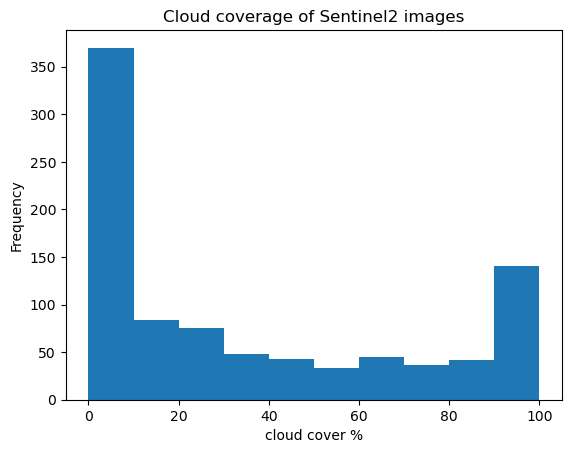

In [22]:
ax: plt.Axes = sentinel_products_metadata.loc[products]['cloudcoverpercentage'].plot(kind='hist', )
ax.set_title('Cloud coverage of Sentinel2 images')
ax.set_xlabel('cloud cover %')

In [23]:
all_metars['timedelta'] = pd.Series(all_metars['datetime'].to_numpy(np.datetime64) \
    - sentinel_products_metadata.loc[all_metars['product_id']]['generationdate'].to_numpy(np.datetime64))

In [24]:
all_metars['datetime'].iloc[0]

Timestamp('2022-08-11 20:53:00+0000', tz='UTC')

In [25]:
sentinel_products_metadata.loc[all_metars['product_id']]['generationdate'].iloc[0]

Timestamp('2022-08-11 21:19:46+0000', tz='UTC')

In [26]:
all_metars['timedelta'].iloc[0]

Timedelta('-1 days +23:33:14')

In [27]:
all_metars['timedelta'].iloc[0].total_seconds()

-1606.0

In [28]:
available_metars = all_metars[(all_metars['product_id'].isin(products)) \
                              & (all_metars['sky_conditions [M]'].map(lambda x: len(x) > 0))].copy()
print(f'{available_metars.shape[0]} of {all_metars.shape[0]} METARs are available'
      f' [{float(available_metars.shape[0]) / float(all_metars.shape[0]) * 100.0:.1f} %]')

4520 of 5886 METARs are available [76.8 %]


In [29]:
available_stations_in_products = []
for product in products:
    product_dir = os.path.join(features_dir, product)
    product_bands = os.listdir(product_dir)
    stations = set()
    for band in product_bands:
        band_dir = os.path.join(product_dir, band)
        stations = stations.union(set([Path(file).stem for file in os.listdir(band_dir)]))
    for station in stations:
        available_stations_in_products += [{'product_id': product, 'station': station}]
available_stations_in_products = pd.DataFrame(available_stations_in_products)

In [30]:
keys = list(available_stations_in_products.columns.values)
i1 = available_metars.set_index(keys).index
i2 = available_stations_in_products.set_index(keys).index
available_metars = available_metars[i1.isin(i2)].copy()
print(f'{available_metars.shape[0]} of {all_metars.shape[0]} METARs are available'
      f' [{float(available_metars.shape[0]) / float(all_metars.shape[0]) * 100.0:.1f} %]')

4487 of 5886 METARs are available [76.2 %]


In [31]:
remaining_stations = available_metars['station'].drop_duplicates().to_numpy()
print(f'{len(remaining_stations)} stations remain')

86 stations remain


In [32]:
station_radius_of_influence = 8000.0 # meters

In [33]:
area_of_interest_df = gpd.read_file('input/USA-florida.geojson')
area_of_interest: MultiPolygon = area_of_interest_df.geometry.iloc[0]
print(type(area_of_interest))

<class 'shapely.geometry.multipolygon.MultiPolygon'>


In [34]:
def plot_florida(ax:plt.Axes, color:str):
    area_of_interest_df['geometry'].buffer(0).boundary.plot(ax=ax, facecolor=color, alpha=1.0, linewidth=0.1, zorder=1)

In [35]:
def reproject_point(point:Point, crs_from, crs_to) -> Point:
    return Point(rasterio.warp.transform_geom(crs_from, crs_to, point)['coordinates'])

def reproject_polygon(polygon:Polygon, crs_from, crs_to) -> Polygon:
    intermediate = rasterio.warp.transform_geom(crs_from, crs_to, polygon)['coordinates']
    return Polygon(*intermediate)

In [36]:
def sphere_of_influence(point:Point, radius:float, crs) -> Polygon:
    crs_intermediate = CRS.from_epsg(32616)
    return reproject_polygon(reproject_point(point, crs, crs_intermediate).buffer(radius),
        crs_intermediate, crs)

In [37]:
remaining_stations_metadata = station_metadata.loc[remaining_stations]

In [38]:
remaining_stations_metadata['geometry'] = remaining_stations_metadata['geometry'].apply(
    lambda x: shapely.box(*sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).bounds)
)

In [39]:
intersections: gpd.GeoDataFrame = remaining_stations_metadata[['geometry']].sjoin(remaining_stations_metadata[['geometry']], predicate="intersects")

In [40]:
intersections = intersections[intersections['index_right'] != intersections.index]

In [41]:
intersections = intersections.sample(frac=1, random_state=1)

In [42]:
intersections.head()

,geometry,index_right
id,,
CEW,"POLYGON ((-86.43640 30.70781, -86.43640 30.85219, -86.60361 30.85219, -86.60361 30.70781, -86.43640 30.70781))",EGI
HRT,"POLYGON ((-86.60603 30.35564, -86.60603 30.50002, -86.77264 30.50002, -86.77264 30.35564, -86.60603 30.35564))",VPS
CRG,"POLYGON ((-81.43186 30.26424, -81.43186 30.40796, -81.59755 30.40796, -81.59755 30.26424, -81.43186 30.26424))",NIP
DAB,"POLYGON ((-80.97621 29.10809, -80.97621 29.25175, -81.13991 29.25175, -81.13991 29.10809, -80.97621 29.10809))",OMN
FLL,"POLYGON ((-80.07056 25.99825, -80.07056 26.14175, -80.22944 26.14175, -80.22944 25.99825, -80.07056 25.99825))",HWO


In [43]:
intersections_groups = intersections[['index_right']].groupby('index_right').groups
print(intersections_groups)

{'BCT': ['PMP'], 'BOW': ['GIF'], 'CEW': ['EGI'], 'COF': ['MLB'], 'CRG': ['NRB', 'NIP'], 'DAB': ['OMN'], 'DTS': ['VPS'], 'EGI': ['CEW'], 'FLL': ['HWO'], 'FMY': ['RSW'], 'GIF': ['BOW'], 'HEG': ['NIP', 'VQQ'], 'HRT': ['VPS'], 'HWO': ['FLL', 'OPF'], 'ISM': ['MCO'], 'LNA': ['PBI'], 'MCF': ['SPG'], 'MCO': ['ISM', 'ORL'], 'MIA': ['OPF'], 'MLB': ['COF'], 'NIP': ['CRG', 'HEG'], 'NPA': ['PNS'], 'NRB': ['CRG'], 'OMN': ['DAB'], 'OPF': ['MIA', 'HWO'], 'ORL': ['MCO'], 'PAM': ['TDR'], 'PBI': ['LNA'], 'PMP': ['BCT'], 'PNS': ['NPA'], 'RSW': ['FMY'], 'SPG': ['MCF'], 'TDR': ['PAM'], 'TIX': ['TTS'], 'TTS': ['TIX'], 'VPS': ['HRT', 'DTS'], 'VQQ': ['HEG']}


In [44]:
import networkx
import networkx.convert
graph = networkx.convert.from_dict_of_lists(intersections_groups)

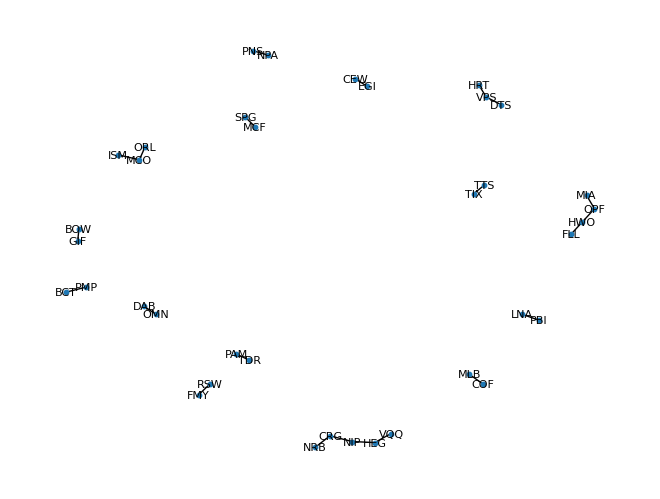

In [45]:
networkx.draw(graph, with_labels=True, font_size=8, node_size=10)

In [46]:
clusters = list(networkx.connected_components(graph))
print(clusters)

[{'BCT', 'PMP'}, {'BOW', 'GIF'}, {'CEW', 'EGI'}, {'COF', 'MLB'}, {'CRG', 'NRB', 'HEG', 'NIP', 'VQQ'}, {'OMN', 'DAB'}, {'VPS', 'HRT', 'DTS'}, {'MIA', 'OPF', 'FLL', 'HWO'}, {'FMY', 'RSW'}, {'ISM', 'ORL', 'MCO'}, {'PBI', 'LNA'}, {'SPG', 'MCF'}, {'PNS', 'NPA'}, {'TDR', 'PAM'}, {'TTS', 'TIX'}]


In [47]:
def get_mapping_from_clusters(clusters:List[Set[str]]):
    mapping = {}
    current_cluster = 0
    for cluster in clusters:
        for node in cluster:
            mapping[node] = current_cluster
        current_cluster += 1
    return mapping

node_to_cluster_mapping = get_mapping_from_clusters(clusters)
print(node_to_cluster_mapping)

{'BCT': 0, 'PMP': 0, 'BOW': 1, 'GIF': 1, 'CEW': 2, 'EGI': 2, 'COF': 3, 'MLB': 3, 'CRG': 4, 'NRB': 4, 'HEG': 4, 'NIP': 4, 'VQQ': 4, 'OMN': 5, 'DAB': 5, 'VPS': 6, 'HRT': 6, 'DTS': 6, 'MIA': 7, 'OPF': 7, 'FLL': 7, 'HWO': 7, 'FMY': 8, 'RSW': 8, 'ISM': 9, 'ORL': 9, 'MCO': 9, 'PBI': 10, 'LNA': 10, 'SPG': 11, 'MCF': 11, 'PNS': 12, 'NPA': 12, 'TDR': 13, 'PAM': 13, 'TTS': 14, 'TIX': 14}


In [48]:
clusted_stations = intersections.index.to_list()
print(clusted_stations)
remaining_stations_metadata['cluster'] = remaining_stations_metadata['name'].apply(
    lambda x: node_to_cluster_mapping[x] if x in clusted_stations else -1
)

['CEW', 'HRT', 'CRG', 'DAB', 'FLL', 'ISM', 'TIX', 'NIP', 'CRG', 'NRB', 'MCO', 'NIP', 'OPF', 'MLB', 'HEG', 'RSW', 'VQQ', 'MCO', 'EGI', 'HWO', 'MCF', 'BCT', 'BOW', 'MIA', 'OPF', 'GIF', 'OMN', 'TTS', 'HWO', 'TDR', 'FMY', 'LNA', 'PAM', 'ORL', 'DTS', 'COF', 'VPS', 'SPG', 'VPS', 'PMP', 'NPA', 'PNS', 'PBI', 'HEG']


<Axes: title={'center': 'Florida'}>

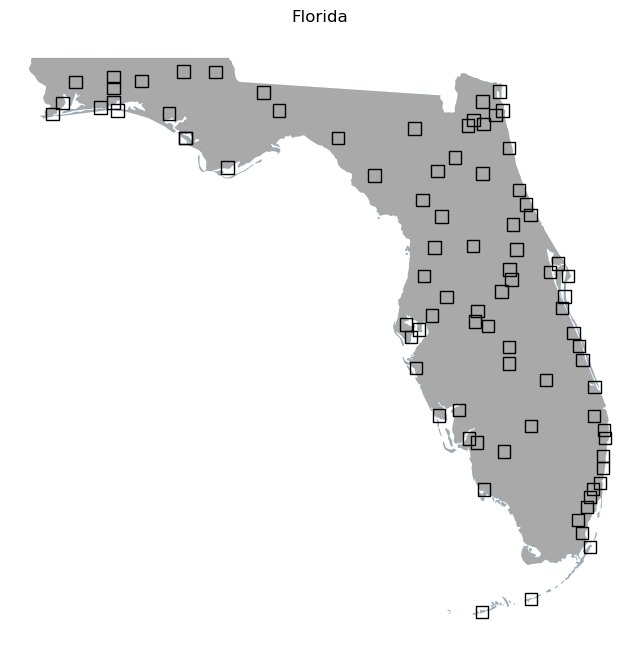

In [87]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal', 'datalim')
ax.set_title('Florida')
ax.axis(False)
plot_florida(ax, 'darkgray')

remaining_stations_metadata.plot(
    ax=ax, facecolor='none', edgecolor='black', legend=True
)

c:\Users\erikw\anaconda3\lib\site-packages\geopandas\plotting.py:642: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


<Axes: title={'center': 'Florida'}>

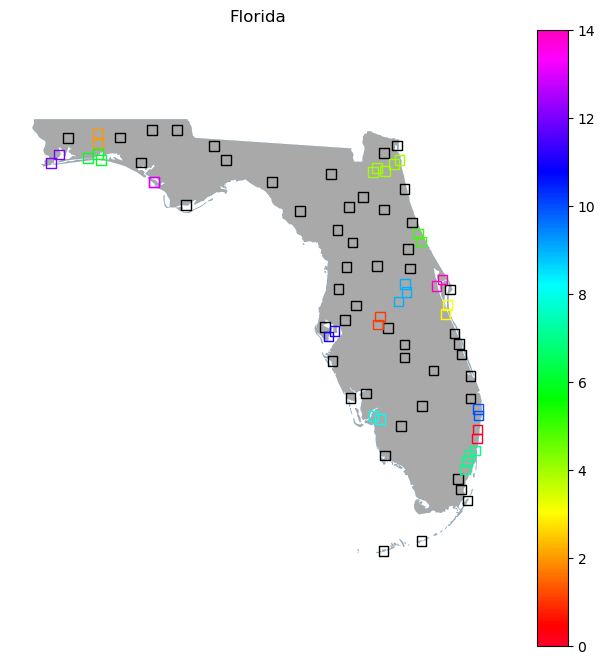

In [88]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal', 'datalim')
ax.set_title('Florida')
ax.axis(False)
plot_florida(ax, 'darkgray')

remaining_stations_metadata[remaining_stations_metadata['cluster'] == -1].plot(
    ax=ax, facecolor='none', edgecolor='black', legend=True
)
remaining_stations_metadata[remaining_stations_metadata['cluster'] != -1].plot(
    column='cluster', ax=ax, facecolor='none', colormap='gist_rainbow', legend=True
)

In [51]:
cloud_covers = pd.DataFrame([available_metars['station'], available_metars['sky_conditions [M]']]).T
cloud_covers['cloud cover'] = cloud_covers['sky_conditions [M]'].apply(lambda sky_conditions: [cond.cover for cond in sky_conditions])
cloud_covers

,station,sky_conditions [M],cloud cover
11,FPY,"[DataSkyConditions(cover='SCT', height=3047.999902464, cloud=None)]",[SCT]
12,FPY,"[DataSkyConditions(cover='BKN', height=3047.999902464, cloud=None)]",[BKN]
13,FPY,"[DataSkyConditions(cover='OVC', height=3047.999902464, cloud=None)]",[OVC]
17,LCQ,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",[CLR]
18,LCQ,"[DataSkyConditions(cover='BKN', height=609.5999804928, cloud=None)]",[BKN]
...,...,...,...
5881,MKY,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",[CLR]
5882,2J9,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",[CLR]
5883,2J9,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",[CLR]
5884,2J9,"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",[CLR]


In [52]:
cloud_covers_flat = [item for sublist in cloud_covers['cloud cover'] for item in sublist]
print(cloud_covers_flat)

['SCT', 'BKN', 'OVC', 'CLR', 'BKN', 'SCT', 'SCT', 'CLR', 'BKN', 'BKN', 'BKN', 'SCT', 'SCT', 'BKN', 'SCT', 'SCT', 'BKN', 'CLR', 'FEW', 'BKN', 'FEW', 'FEW', 'CLR', 'SCT', 'BKN', 'OVC', 'CLR', 'CLR', 'BKN', 'FEW', 'BKN', 'BKN', 'SCT', 'BKN', 'BKN', 'BKN', 'BKN', 'BKN', 'BKN', 'BKN', 'OVC', 'BKN', 'OVC', 'BKN', 'OVC', 'OVC', 'OVC', 'OVC', 'SCT', 'BKN', 'OVC', 'SCT', 'BKN', 'OVC', 'BKN', 'BKN', 'OVC', 'SCT', 'BKN', 'OVC', 'BKN', 'BKN', 'OVC', 'BKN', 'OVC', 'SCT', 'BKN', 'BKN', 'BKN', 'SCT', 'SCT', 'SCT', 'BKN', 'OVC', 'SCT', 'SCT', 'BKN', 'OVC', 'SCT', 'BKN', 'BKN', 'BKN', 'OVC', 'BKN', 'BKN', 'OVC', 'BKN', 'OVC', 'BKN', 'OVC', 'BKN', 'OVC', 'BKN', 'OVC', 'BKN', 'BKN', 'OVC', 'BKN', 'OVC', 'FEW', 'OVC', 'SCT', 'SCT', 'SCT', 'SCT', 'SCT', 'SCT', 'SCT', 'SCT', 'SCT', 'BKN', 'OVC', 'FEW', 'BKN', 'OVC', 'BKN', 'OVC', 'BKN', 'BKN', 'BKN', 'OVC', 'OVC', 'OVC', 'BKN', 'OVC', 'BKN', 'BKN', 'FEW', 'BKN', 'OVC', 'FEW', 'OVC', 'OVC', 'BKN', 'OVC', 'BKN', 'OVC', 'SCT', 'CLR', 'SCT', 'SCT', 'OVC', 'SCT'

<Axes: >

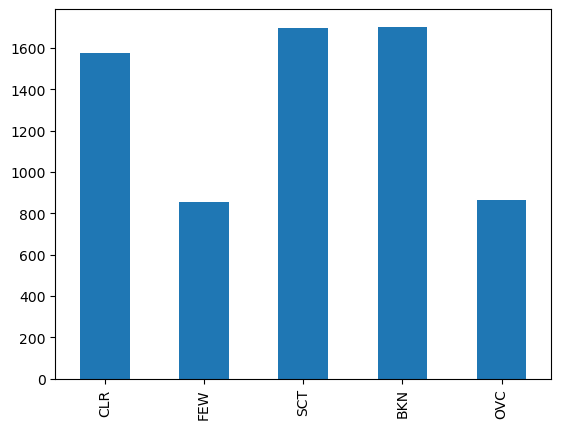

In [53]:
pd.Series(dict(Counter(cloud_covers_flat))).loc[cloud_covers_order].plot(kind='bar')

In [54]:
cloud_cover_strength = {
    'CLR': 1,
    'SCT': 3,
    'BKN': 5,
    'OVC': 8
}

def get_max_cloud_cover(cloud_covers:List[DataSkyConditions]):
    cloud_covers_ranked = [(cloud_cover_strength[cc.cover],cc.cover) if cc.cover in cloud_cover_strength else (-1,cc.cover) for cc in cloud_covers]
    if any(cloud_covers_ranked):
        return max(cloud_covers_ranked)[1]
    else:
        return None

In [55]:
available_metars['max cloud cover'] = available_metars['sky_conditions [M]'].apply(get_max_cloud_cover)

In [56]:
cloud_covers['cloud cover max'] = cloud_covers['sky_conditions [M]'].map(get_max_cloud_cover)
cloud_covers['cloud cover max']

11      SCT
12      BKN
13      OVC
17      CLR
18      BKN
       ... 
5881    CLR
5882    CLR
5883    CLR
5884    CLR
5885    CLR
Name: cloud cover max, Length: 4487, dtype: object

In [57]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))

SCT     792
BKN     874
OVC     865
CLR    1577
FEW     377
VV        2
dtype: int64

<Axes: title={'center': 'Maximum cloud coverage by weather stations'}>

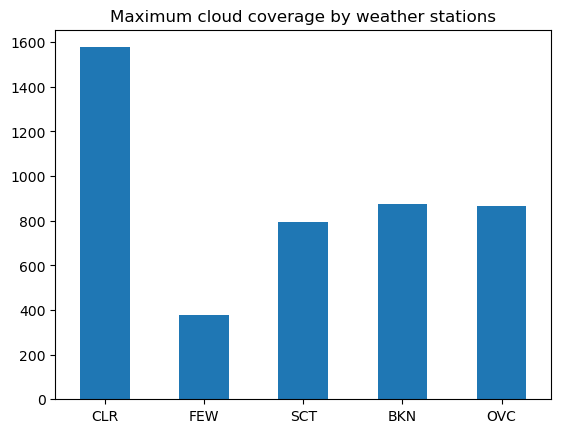

In [58]:
pd.Series(dict(Counter(cloud_covers['cloud cover max'])))\
    .loc[cloud_covers_order].plot(kind='bar', title='Maximum cloud coverage by weather stations', rot=0)

In [59]:
cloud_covers_max_per_station = {}
for station, data in cloud_covers.groupby('station'):
    cloud_covers_max_per_station[station] = pd.Series(dict(Counter(data['cloud cover max'])))
cloud_covers_max_per_station = pd.DataFrame(cloud_covers_max_per_station)
cloud_covers_max_per_station

,28J,2IS,2J9,42J,54A,54J,AAF,AGR,BCR,BCT,...,TTS,VDF,VPS,VQQ,VRB,X07,X26,X60,XMR,ZPH
BKN,13.0,10.0,9.0,12.0,11.0,10.0,8,NaN,7.0,3.0,...,10.0,18.0,6.0,15.0,4.0,13.0,27.0,24.0,16.0,11.0
CLR,31.0,32.0,47.0,30.0,23.0,30.0,48,4.0,14.0,4.0,...,18.0,26.0,17.0,8.0,8.0,26.0,80.0,28.0,35.0,30.0
FEW,10.0,NaN,10.0,15.0,12.0,NaN,4,1.0,2.0,6.0,...,5.0,NaN,3.0,1.0,6.0,12.0,NaN,NaN,10.0,NaN
OVC,22.0,12.0,10.0,16.0,12.0,22.0,3,2.0,10.0,1.0,...,3.0,9.0,17.0,1.0,12.0,14.0,36.0,15.0,4.0,16.0
SCT,11.0,15.0,10.0,8.0,6.0,9.0,1,1.0,3.0,13.0,...,4.0,19.0,14.0,8.0,9.0,12.0,39.0,13.0,11.0,24.0
VV,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
available_metars[(available_metars['station'] == 'COF') & (available_metars['product_id'] == 'ccf77509-d1f6-4a12-980e-97f259844ca1')]

,station,datetime,temperature [C],current_weather,recent_weather,sky_conditions [M],metar_code,product_id,timedelta,max cloud cover
977,COF,2023-01-18 19:55:00+00:00,23.0,[],[],"[DataSkyConditions(cover='CLR', height=None, cloud=None)]",KCOF 181955Z AUTO 11008KT 10SM CLR 23/16 A3003 RMK AO2 SLP174 T02300156 $,ccf77509-d1f6-4a12-980e-97f259844ca1,0 days 00:16:44,CLR


In [61]:
available_metars[(available_metars['station'] == 'COF') & (available_metars['product_id'] == 'f6e6aca3-e682-44b0-b335-cd3c16eebb48')].iloc[0]['timedelta'].seconds

85990

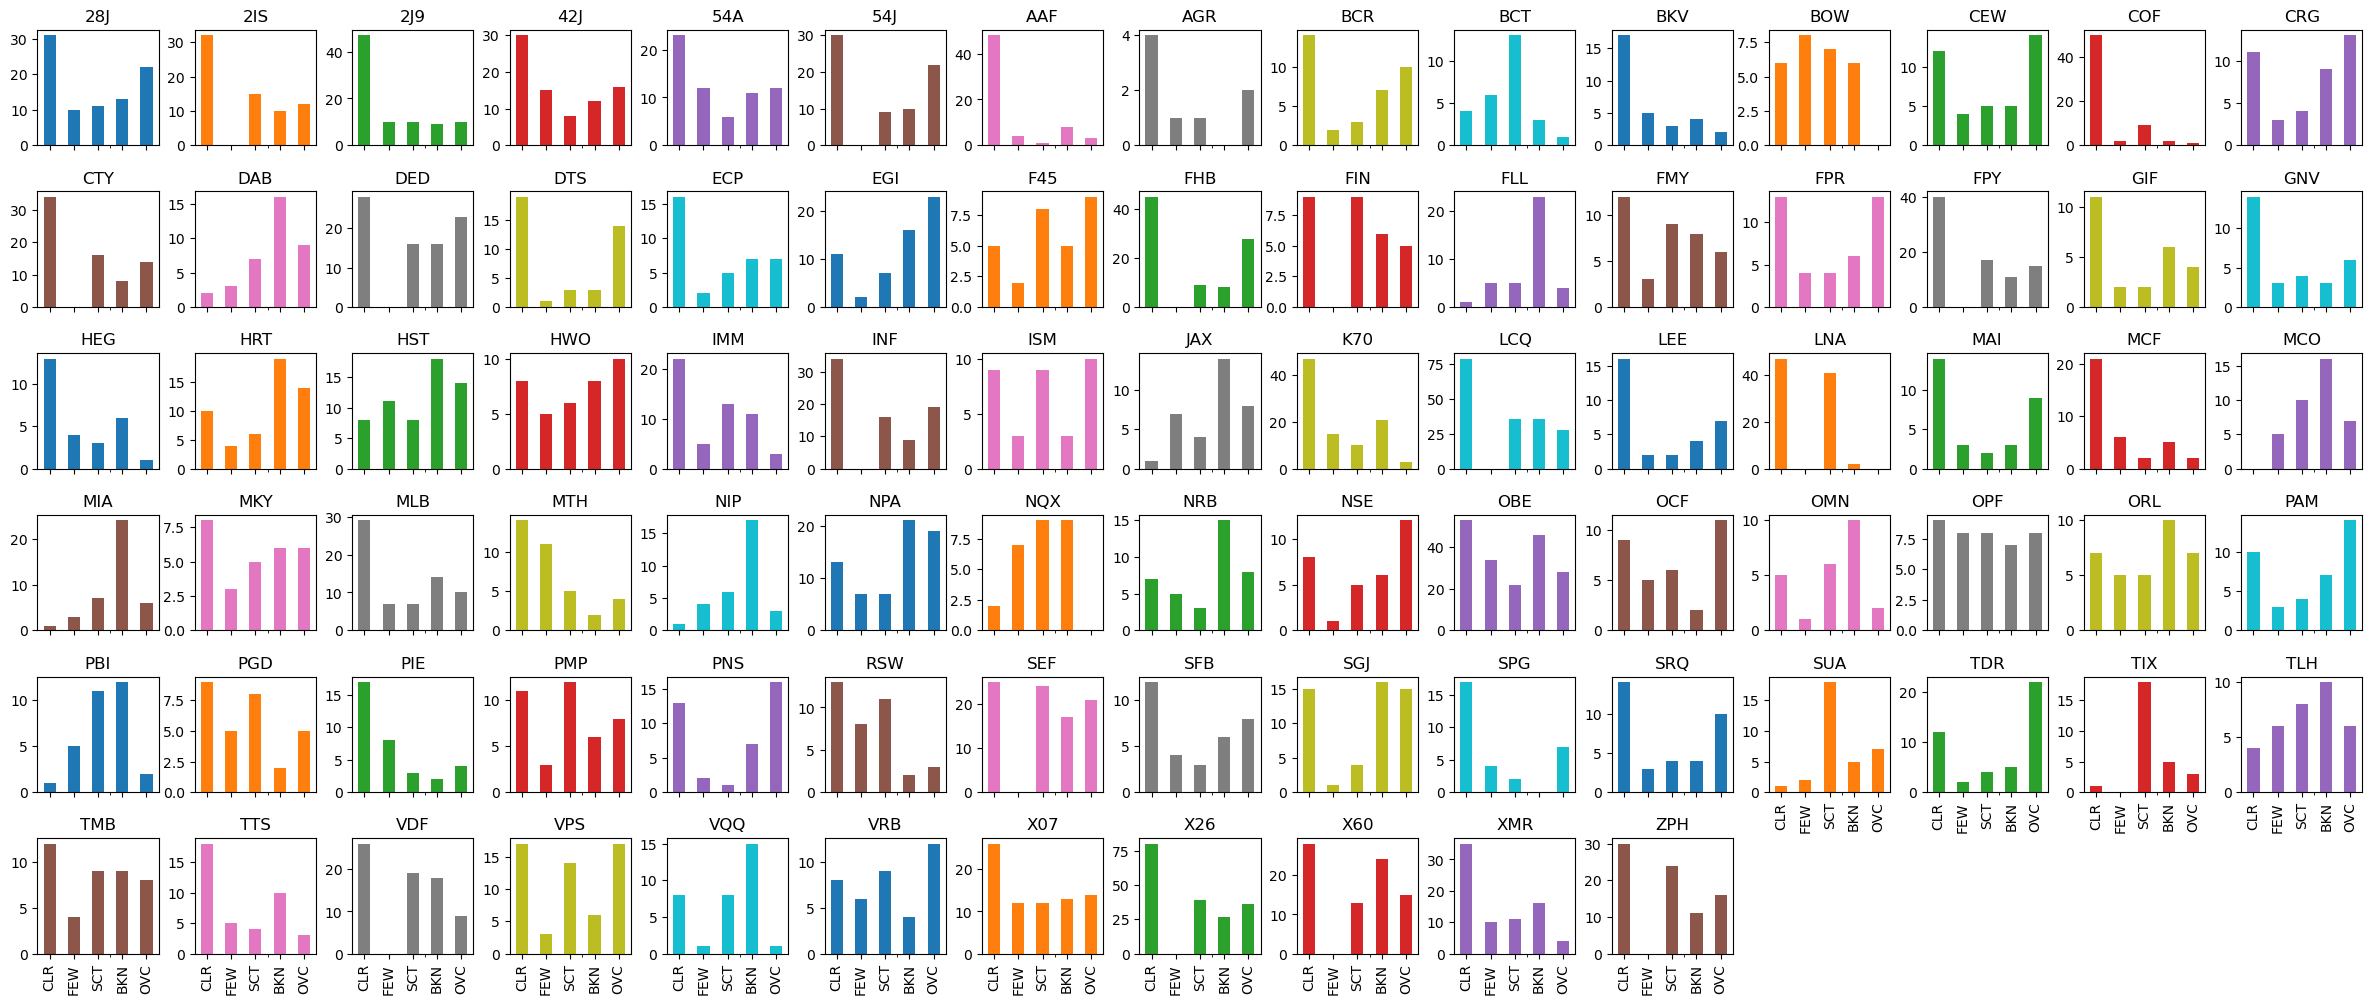

In [62]:
from numpy import ceil

plot_share_x = True
plot_layout_scale = 2.0
plot_layout_columns = 15
plot_layout_rows = int(ceil(cloud_covers_max_per_station.shape[1] / plot_layout_columns))
cloud_covers_max_per_station.loc[cloud_covers_order].plot(kind='bar', sharex=plot_share_x, subplots=True, legend=False,
    layout=(plot_layout_rows, plot_layout_columns),
    figsize=(plot_layout_columns * plot_layout_scale, plot_layout_rows * plot_layout_scale))
if not plot_share_x:
    plt.subplots_adjust(wspace=0.3, hspace=1.0)
else:
    plt.subplots_adjust(wspace=0.3, hspace=0.4)

In [63]:
metars_no_multiple_station_observations = available_metars.drop_duplicates(subset=['station', 'product_id'])
print(f'{metars_no_multiple_station_observations.shape[0]} of {available_metars.shape[0]}'
      ' METARs are left when removing additional observations of the same station per product'
      f' [{float(metars_no_multiple_station_observations.shape[0]) / float(available_metars.shape[0]) * 100.0:.1f} %]')
metar_station_counts = metars_no_multiple_station_observations.groupby(['station'])['product_id'].count().sort_values()

2601 of 4487 METARs are left when removing additional observations of the same station per product [58.0 %]


<Axes: xlabel='station'>

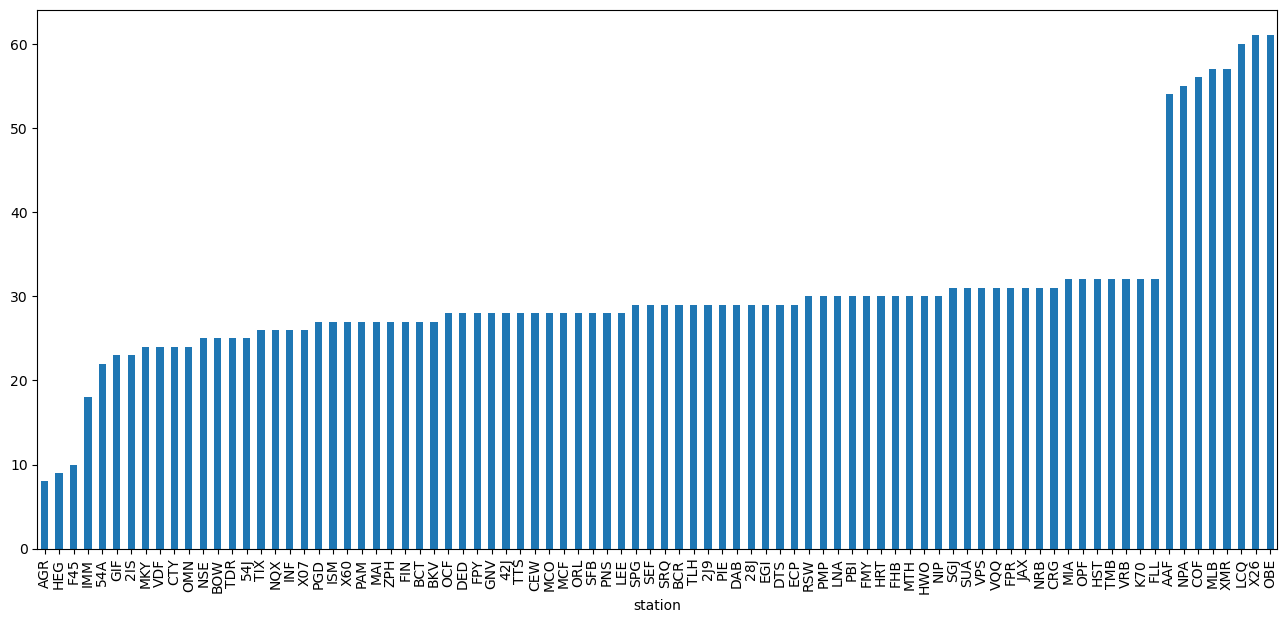

In [64]:
metar_station_counts.plot(kind='bar', figsize=(16,7))

<Axes: ylabel='Frequency'>

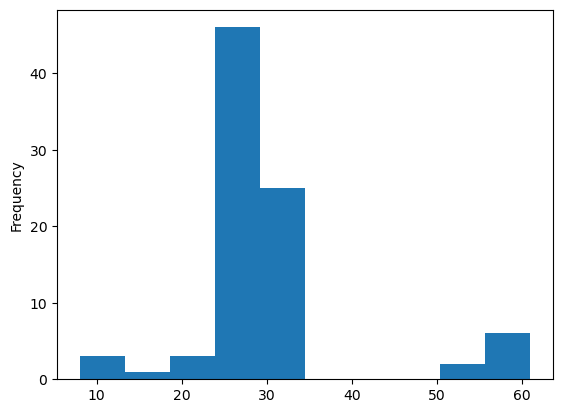

In [65]:
metar_station_counts.plot(kind='hist')

In [66]:
station_quantity = available_metars.groupby('station')['product_id'].count()
station_quantity

station
28J     87
2IS     69
2J9     86
42J     81
54A     64
      ... 
X07     77
X26    182
X60     80
XMR     76
ZPH     81
Name: product_id, Length: 86, dtype: int64

In [67]:
@dataclass
class DatasetUnit:
    stations: Set[str]
    quantity: int

    def __lt__(self, other):
         return (self.quantity, self.stations) < (other.quantity, self.stations)

In [68]:
stations_not_in_cluster = set(remaining_stations_metadata['name']).difference(set.union(*clusters))
print(stations_not_in_cluster)

{'F45', 'SUA', 'FIN', 'K70', 'VDF', 'SRQ', 'MAI', 'VRB', 'NSE', 'NQX', 'JAX', 'TLH', '28J', '54J', 'SEF', 'ECP', 'MKY', 'SGJ', 'HST', 'FPY', 'AAF', 'AGR', 'BKV', 'MTH', 'OBE', '2IS', 'XMR', 'LCQ', '2J9', 'SFB', 'FPR', 'CTY', 'OCF', 'GNV', 'PIE', 'DED', '42J', 'TMB', 'ZPH', 'FHB', 'X07', '54A', 'X26', 'IMM', 'LEE', 'PGD', 'X60', 'BCR', 'INF'}


In [69]:
dataset_units: List[DatasetUnit] = []
for cluster in clusters:
    dataset_units += [DatasetUnit(cluster, sum([station_quantity.loc[station] for station in cluster]))]
dataset_units += [DatasetUnit(set([station]), station_quantity.loc[station]) for station in stations_not_in_cluster]
print(dataset_units)

[DatasetUnit(stations={'BCT', 'PMP'}, quantity=67), DatasetUnit(stations={'BOW', 'GIF'}, quantity=52), DatasetUnit(stations={'CEW', 'EGI'}, quantity=99), DatasetUnit(stations={'COF', 'MLB'}, quantity=131), DatasetUnit(stations={'CRG', 'NRB', 'HEG', 'NIP', 'VQQ'}, quantity=169), DatasetUnit(stations={'OMN', 'DAB'}, quantity=61), DatasetUnit(stations={'VPS', 'HRT', 'DTS'}, quantity=150), DatasetUnit(stations={'MIA', 'OPF', 'FLL', 'HWO'}, quantity=156), DatasetUnit(stations={'FMY', 'RSW'}, quantity=75), DatasetUnit(stations={'ISM', 'ORL', 'MCO'}, quantity=106), DatasetUnit(stations={'PBI', 'LNA'}, quantity=121), DatasetUnit(stations={'SPG', 'MCF'}, quantity=66), DatasetUnit(stations={'PNS', 'NPA'}, quantity=106), DatasetUnit(stations={'TDR', 'PAM'}, quantity=83), DatasetUnit(stations={'TTS', 'TIX'}, quantity=67), DatasetUnit(stations={'F45'}, quantity=29), DatasetUnit(stations={'SUA'}, quantity=33), DatasetUnit(stations={'FIN'}, quantity=29), DatasetUnit(stations={'K70'}, quantity=96), Da

Text(0.5, 0, 'Average number of METARS per satellite image')

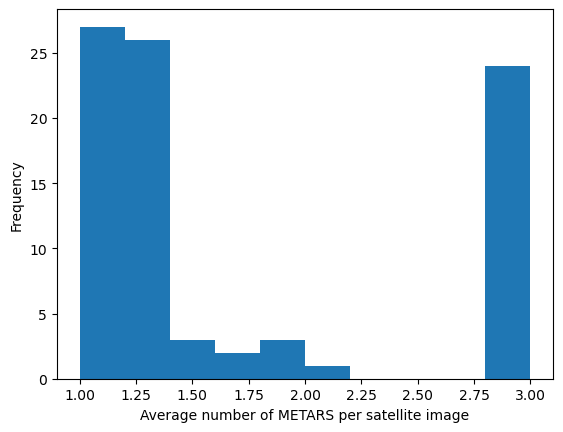

In [70]:
ax: plt.Axes = available_metars.groupby(['station', 'product_id'])['datetime'].count().groupby('station').mean().plot(kind='hist')
ax.set_xlabel('Average number of METARS per satellite image')

Text(0.5, 0, 'quantity of METARs')

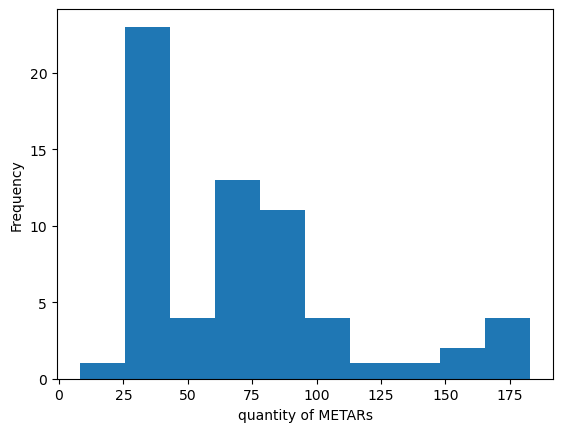

In [71]:
ax: plt.Axes = pd.DataFrame(dataset_units).plot(kind='hist', legend=False)
ax.set_xlabel('quantity of METARs')

In [72]:
total_quantity = sum([entry.quantity for entry in dataset_units])
print(f'In total, {total_quantity} units of data are to be distributed for the dataset')

In total, 4487 units of data are to be distributed for the dataset


In [73]:
@dataclass
class DatasetSplit:
    training: float
    validation: float
    test: float

    def __init__(self, training: float, validation: float, test: float) -> None:
        if not math.isclose(training + validation + test, 1.0):
            raise ValueError('DatasetSplit must sum to 1.0 (100 %)')
        self.training = training
        self.validation = validation
        self.test = test
    
    def getAbsoluteNumbers(self, total_quantity:int) -> Tuple[int, int, int]:
        test_abs        = int(math.ceil(total_quantity * self.test))
        validation_abs  = int(math.ceil(total_quantity * self.validation))
        training_abs    = total_quantity - test_abs - validation_abs
        return (training_abs, validation_abs, test_abs)

In [74]:
dataset_split = DatasetSplit(0.70, 0.15, 0.15)
num_training, num_validation, num_test = dataset_split.getAbsoluteNumbers(total_quantity)
print(f'DatasetSplit target:'
      f'\nTraining:\t{num_training}\t[{dataset_split.training * 100.0:.1f} %]'
      f'\nValidation:\t{num_validation}\t[{dataset_split.validation * 100.0:.1f} %]'
      f'\nTest:\t\t{num_test}\t[{dataset_split.test * 100.0:.1f} %]')

DatasetSplit target:
Training:	3139	[70.0 %]
Validation:	674	[15.0 %]
Test:		674	[15.0 %]


In [75]:
dataset_units.sort(reverse=True)
dataset_units

[DatasetUnit(stations={'OBE'}, quantity=183),
 DatasetUnit(stations={'X26'}, quantity=182),
 DatasetUnit(stations={'LCQ'}, quantity=179),
 DatasetUnit(stations={'CRG', 'NRB', 'HEG', 'NIP', 'VQQ'}, quantity=169),
 DatasetUnit(stations={'MIA', 'OPF', 'FLL', 'HWO'}, quantity=156),
 DatasetUnit(stations={'VPS', 'HRT', 'DTS'}, quantity=150),
 DatasetUnit(stations={'COF', 'MLB'}, quantity=131),
 DatasetUnit(stations={'PBI', 'LNA'}, quantity=121),
 DatasetUnit(stations={'ISM', 'ORL', 'MCO'}, quantity=106),
 DatasetUnit(stations={'PNS', 'NPA'}, quantity=106),
 DatasetUnit(stations={'CEW', 'EGI'}, quantity=99),
 DatasetUnit(stations={'K70'}, quantity=96),
 DatasetUnit(stations={'FHB'}, quantity=90),
 DatasetUnit(stations={'28J'}, quantity=87),
 DatasetUnit(stations={'SEF'}, quantity=87),
 DatasetUnit(stations={'2J9'}, quantity=86),
 DatasetUnit(stations={'TDR', 'PAM'}, quantity=83),
 DatasetUnit(stations={'FPY'}, quantity=83),
 DatasetUnit(stations={'DED'}, quantity=83),
 DatasetUnit(stations={

In [76]:
@dataclass
class Dataset:
    data: List[DatasetUnit]
    current_size: int
    target_size: int

    def add(self, unit:DatasetUnit):
        self.data += [unit]
        self.current_size += unit.quantity

    def get_missing_quantity(self) -> int:
        return self.target_size - self.current_size
    
    def get_stations(self) -> Set[str]:
        return set.union(*[x.stations for x in self.data])

In [77]:
def greedy_partition(split:DatasetSplit, total_quantity:int, data:List[DatasetUnit]):
    num_training, num_validation, num_test = dataset_split.getAbsoluteNumbers(total_quantity)
    training    = Dataset([], 0, num_training)
    validation  = Dataset([], 0, num_validation)
    test        = Dataset([], 0, num_test)
    for unit in data:
        # Get the dataset that is missing the most data
        next_dataset = max([
            (training.get_missing_quantity(),      training),
            (validation.get_missing_quantity(),  validation),
            (test.get_missing_quantity(),              test)
        ], key=lambda x: x[0])[1]
        next_dataset.add(unit)
    return (training, validation, test)

In [78]:
training, validation, test = greedy_partition(dataset_split, total_quantity, dataset_units)
print(f'DatasetSplit:'
      f'\nTraining:\t{training.current_size}\t[{float(training.current_size) / float(total_quantity) * 100.0:.1f} %]'
      f'\nValidation:\t{validation.current_size}\t[{float(validation.current_size) / float(total_quantity) * 100.0:.1f} %]'
      f'\nTest:\t\t{test.current_size}\t[{float(test.current_size) / float(total_quantity) * 100.0:.1f} %]')

DatasetSplit:
Training:	3144	[70.1 %]
Validation:	672	[15.0 %]
Test:		671	[15.0 %]


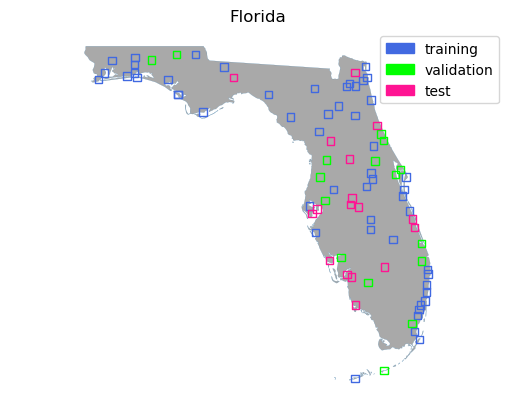

In [84]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Florida')
ax.axis(False)
plot_florida(ax, 'darkgray')

color_training = 'royalblue'
color_validation = 'lime'
color_test = 'deeppink'

patch_training = mpatches.Patch(color=color_training, label='training')
patch_validation = mpatches.Patch(color=color_validation, label='validation')
patch_test = mpatches.Patch(color=color_test, label='test')

remaining_stations_metadata.loc[list(training.get_stations())].plot(
    ax=ax, facecolor='none', edgecolor=color_training, legend=True
)
remaining_stations_metadata.loc[list(validation.get_stations())].plot(
    ax=ax, facecolor='none', edgecolor=color_validation, legend=True
)
remaining_stations_metadata.loc[list(test.get_stations())].plot(
    ax=ax, facecolor='none', edgecolor=color_test, legend=True
)

ax.legend(handles=[patch_training, patch_validation, patch_test])

In [74]:
os.makedirs(dataset_dir, exist_ok=True)
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')
os.makedirs(training_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [75]:
print(training.get_stations())

{'DED', 'SRQ', 'CEW', 'HRT', 'BKV', 'ORL', 'NPA', 'NIP', 'PAM', 'X60', 'AGR', 'X26', '42J', 'NRB', 'OBE', 'HEG', 'PNS', 'MCO', 'TDR', 'ZPH', 'PMP', 'EGI', 'ISM', 'LCQ', 'OPF', 'FLL', 'SGJ', 'FPY', '28J', 'NQX', 'XMR', 'PBI', 'HST', 'CRG', 'VQQ', 'DTS', 'MLB', 'SEF', 'MIA', 'PIE', 'NSE', 'K70', 'HWO', '2J9', 'AAF', 'GNV', 'LNA', 'FHB', 'ECP', 'CTY', 'VPS', 'COF', 'BCT'}


In [84]:
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
band_resolutions_meters = [60, 10, 10, 10, 20, 20, 20, 10, 20, 60, 60, 20, 20]

In [85]:
def get_features_path(station:str, product_id:str, band:str):
    return os.path.join(features_dir, product_id, band, f'{station}.jp2')

def get_dataset_local_dir(station:str, product_id:str):
    return os.path.join(station, product_id)

def get_dataset_path(target_dir:str, station:str, product_id:str, band:str):
    return os.path.join(target_dir, get_dataset_local_dir(station, product_id), f'{band}.jp2')

def map_files_to_dataset_paths(dataset:Dataset, target_dir:str) -> List[Tuple[str, str]]:
    data_subset = available_metars[(available_metars['station'].isin(dataset.get_stations()))\
                                   & (available_metars['max cloud cover'].isin(cloud_covers_order))]
    result = data_subset.apply(
        lambda x: [(get_features_path(x.station, x.product_id, band),
                    get_dataset_path(target_dir, x.station, x.product_id, band)) for band in bands], axis=1)
    return [x for sublist in result for x in sublist]

In [86]:
dataset_file_mappings = [mapping for sublist in [
    map_files_to_dataset_paths(training, training_dir),
    map_files_to_dataset_paths(validation, validation_dir),
    map_files_to_dataset_paths(test, test_dir)
] for mapping in sublist]

In [87]:
for path_from, path_to in dataset_file_mappings:
    os.makedirs(os.path.dirname(path_to), exist_ok=True)
    if not os.path.exists(path_to):
        shutil.copyfile(path_from, path_to)

In [88]:
def create_dataset_labels(dataset:Dataset):
    labels = available_metars[available_metars['station'].isin(dataset.get_stations())\
                              & (available_metars['max cloud cover'].isin(cloud_covers_order))].copy()
    labels['dir'] = labels.apply(lambda x: get_dataset_local_dir(x.station, x.product_id), axis=1)
    labels['timedelta [minutes]'] = labels['timedelta'].map(lambda x: x.total_seconds() / 60.0)
    labels = labels[['max cloud cover', 'temperature [C]', 'timedelta [minutes]', 'dir']]
    return labels

In [89]:
training_labels = create_dataset_labels(training)
validation_labels = create_dataset_labels(validation)
test_labels = create_dataset_labels(test)

In [90]:
training_labels

,max cloud cover,temperature [C],timedelta [minutes],dir
11,SCT,27.9,-19.000000,FPY\2830479a-06b5-4a29-955b-2d496b23a0f0
12,BKN,27.5,1.000000,FPY\2830479a-06b5-4a29-955b-2d496b23a0f0
13,OVC,27.5,21.000000,FPY\2830479a-06b5-4a29-955b-2d496b23a0f0
17,CLR,27.0,-19.000000,LCQ\3d838361-abac-4c8b-bc2d-5a3e09e779cb
18,BKN,27.0,1.000000,LCQ\3d838361-abac-4c8b-bc2d-5a3e09e779cb
...,...,...,...,...
5879,CLR,17.8,24.183333,PMP\ffb370c5-e380-424c-9ddc-ba0f76149481
5880,CLR,17.2,-15.566667,AAF\18c3f7bd-770f-4b26-961b-ac68d02da934
5882,CLR,11.0,-11.866667,2J9\fe7d114a-04a0-4575-863f-e0ba7b89afcb
5883,CLR,12.0,8.133333,2J9\fe7d114a-04a0-4575-863f-e0ba7b89afcb


In [91]:
training_labels.to_csv(os.path.join(dataset_dir, 'training_labels.csv'), index=False)
validation_labels.to_csv(os.path.join(dataset_dir, 'validation_labels.csv'), index=False)
test_labels.to_csv(os.path.join(dataset_dir, 'test_labels.csv'), index=False)

In [92]:
bands_metadata = pd.DataFrame([bands, band_resolutions_meters]).T
bands_metadata.columns = ['band', 'resolution [M]']
bands_metadata

,band,resolution [M]
0,B1,60
1,B2,10
2,B3,10
3,B4,10
4,B5,20
5,B6,20
6,B7,20
7,B8,10
8,B8A,20
9,B9,60


In [93]:
bands_metadata.to_csv(os.path.join(dataset_dir, 'bands_metadata.csv'), index=False)